In [289]:
import pandas as pd
import numpy as np
import seaborn as sns
import mysql.connector
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Load Dataset

In [108]:
log2_cols = [
    "sentiment", "publication_url", "product_url", 
    "click", "gender" ,"age_group"
]

log2 = pd.read_csv("data/log2.csv", names = log2_cols)
print(log2.shape)
log2.head(2)

(10000, 6)


,sentiment,publication_url,product_url,click,gender,age_group
0,positive,https://www.foxnews.com/,https://lees.com/jeans,0,female,juvenile
1,neutral,https://www.mirror.co.uk/news/,https://coach.com/purses,0,male,young


In [109]:
product_categories = pd.read_csv("data/product_categories.csv")
print(product_categories.shape)
product_categories.head(2)

(25, 2)


,product,category
0,blender,small kitchen appliances
1,pressure cooker,small kitchen appliances


In [110]:
products = pd.read_csv("data/products.csv")
print(products.shape)
products.head(2)

(51, 3)


,product,product_URL,product_type
0,Vitamix blender,https://vitamix.com/blenders,blender
1,Lenova laptop,https://lenova.com/laptops,computer


# Data Cleaning

There are some extra spaces in front of some prodcut type. Will we remove them.

In [111]:
new_prod_type = []
for x in products["product_type"].values:
    if x[0] == " ":
        new_prod_type.append(x[1:])
    else:
        new_prod_type.append(x)
        
products["product_type"] = new_prod_type 

# 1. Identify corrupted URLs

In [112]:
# correupted if Product_url does not occur in products table
corrupted_url = list()
url_l = np.unique(products["product_URL"])

for x in log2.itertuples():
    if x.product_url not in url_l:
        corrupted_url.append(x.product_url)
        
corrupted_url = np.unique(corrupted_url)
print("Number of corrupted URLs:", len(corrupted_url))
print("Some examples of corrupted URLs:")
for x in corrupted_url[:10]:
    print(x)

Number of corrupted URLs: 216
Some examples of corrupted URLs:
http://maybellije.com/lipstick
http://maybelline.com/lipstuck
http://maybelline.com/xipstick
http://nejoK.co/blenders
http://nemoK.co/blendess
http://nemoK.no/blenders
http://nemoK.wo/blenders
https://HamdltonBeach/blenders
https://HamilbonBeach/blenders
https://HamiloonBeach/blenders


# 2. Clean corrupted URLs

One way to correct the corrupted URLs is by finding if there is any similar URLs in the list of URLs provided by the products data. If there exists an similar enough URL in the products data, we can assume that the corrupted URL is a typo of the original URL. We can then correct it by replacing it with the similar URL. To find the similarity, we can use Jaccard similarity, which is a statistics used for computing similarity between sets. [1] After computing the Jaccard similrity between the corrupted URL and all URLs provided by products.csv, we want to set a threshold high enough to filter out non-matching URLs so that we don't end up with many false positive matchings. 

In practice, we would like to find this threshold by plotting the false positive rate against different level of thresohold and retrieve the optimal point. However, this requires first matching all corrupted URLs with the corresponding potential correct URLs, so for our convenience, we set an arbituary level of 0.85 as our threshold. Therefore, if the corrupted URL has a Jaccard similarity higher than 0.85 with any provided URL, we replace it with the correct version of the URL. Otherwise, we drop it from the dataset.

One limitation of this approach is that the method is not very scalable. If we have a larget set of URLs, for each corrupted URLs, we have to compute its Jaccard similarity with every potential URL.

In [113]:
# https://stackoverflow.com/questions/46975929/how-can-i-calculate-the-jaccard-similarity-of-two-lists-containing-strings-in-py
def jaccard_similarity(list1, list2):
    """compute Jaccard similarity between 2 strings"""
    s1 = set(list1)
    s2 = set(list2)
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

def correct_url(x, url_l, threshold=0.85):
    """correct corrupted urls, return correct url if top Jaccard """
    """similarity is greater than threshold, otherwise return None """
    jaccard_l = list()
    for url in url_l:
        jaccard = jaccard_similarity(x, url)
        jaccard_l.append(jaccard)
        
    top_similarity = np.max(jaccard_l)
    if top_similarity > threshold:
        top_idx = np.argmax(jaccard_l)
        return url_l[top_idx]
    else:
        return None

In [114]:
#Looking through some examples
for x in corrupted_url[:5]:
    print("Corrupted:", x, "| Cleaned:", correct_url(x, url_l))


Corrupted: http://maybellije.com/lipstick | Cleaned: http://maybelline.com/lipstick
Corrupted: http://maybelline.com/lipstuck | Cleaned: http://maybelline.com/lipstick
Corrupted: http://maybelline.com/xipstick | Cleaned: http://maybelline.com/lipstick
Corrupted: http://nejoK.co/blenders | Cleaned: http://nemoK.co/blenders
Corrupted: http://nemoK.co/blendess | Cleaned: http://nemoK.co/blenders


In [115]:
# Apply to the dataset
cleaned_url = list()
for x in log2.itertuples():
    if x.product_url not in url_l:
        cleaned_url.append(correct_url(x.product_url, url_l))
    else:
        cleaned_url.append(x.product_url)
log2["product_url"] = cleaned_url

In [116]:
cnt = 0
for x in log2.itertuples():
    if x.product_url not in url_l:
        cnt += 1
print(cnt)

0


# 3. Find all website that has an Ad for each product

In [326]:
all_publications = list()
product_l = np.unique(products["product"].values)
for x in product_l:
    product_url = products[products["product"] == x]["product_URL"].values[0]
    #find matching product url
    subset = log2[log2["product_url"] == product_url]
    publication_url = np.unique(subset["publication_url"])
    all_publications.append(publication_url)


product_publication = {
    product_l[i]: all_publications[i] for i in range(len(product_l))
}

product_publication

{'Apple computer': array(['https://abcnews.go.com/', 'https://nypost.com/',
        'https://techcrunch.com/', 'https://www.boston.com',
        'https://www.bostonglobe.com/', 'https://www.cbsnews.com/',
        'https://www.cnet.com/', 'https://www.cnn.com/',
        'https://www.dallasnews.com/', 'https://www.engadget.com/',
        'https://www.mirror.co.uk/news/', 'https://www.nj.com',
        'https://www.nydailynews.com/', 'https://www.upworthy.com/',
        'https://www.usatoday.com/', 'https://www.vox.com/'], dtype=object),
 'Apple iPad': array(['https://mashable.com/', 'https://nypost.com/',
        'https://www.al.com/', 'https://www.boston.com',
        'https://www.businessinsider.com/',
        'https://www.chicagotribune.com/', 'https://www.cnn.com/',
        'https://www.examiner.com/', 'https://www.latimes.com/',
        'https://www.mirror.co.uk/news/', 'https://www.nj.com',
        'https://www.npr.org/', 'https://www.sfgate.com/',
        'https://www.slate.com/', 

# 4. Find all website that has an Ad for each product type

In [118]:
def product_type_publication(product_type):
    """Find all publication urls for a product type"""
    #first find all the products in the product type
    subset = products[products["product_type"] == product_type]
    all_products = np.unique(subset["product_URL"])

    #next we find the subset of log2 that contains the products
    subset2 = log2[log2["product_url"].isin(all_products)]
    
    #find all publications
    all_publications = np.unique(subset2["publication_url"])
    
    return all_publications

In [119]:
product_type_pub = list()
product_type_l = np.unique(products["product_type"])

#find all publication sites for each product type
for product_type in product_type_l:
    all_publications = product_type_publication(product_type)
    product_type_pub.append(all_publications)

product_type_pub_d = {
    product_type_l[i]: product_type_pub[i] for i in range(len(product_type_l))
}

product_type_pub_d

{'blender': array(['https://abcnews.go.com/', 'https://mashable.com/',
        'https://nypost.com/', 'https://techcrunch.com/',
        'https://time.com/', 'https://www.al.com/',
        'https://www.boston.com', 'https://www.bostonglobe.com/',
        'https://www.businessinsider.com/', 'https://www.cbsnews.com/',
        'https://www.cnn.com/', 'https://www.dailymail.co.uk/',
        'https://www.dallasnews.com/', 'https://www.examiner.com/',
        'https://www.foxnews.com/', 'https://www.huffingtonpost.com/',
        'https://www.independent.co.uk/', 'https://www.latimes.com/',
        'https://www.nbcnews.com/', 'https://www.nj.com',
        'https://www.npr.org/', 'https://www.nydailynews.com/',
        'https://www.nytimes.com/', 'https://www.salon.com/',
        'https://www.sfgate.com/', 'https://www.telegraph.co.uk/',
        'https://www.theatlantic.com/', 'https://www.theguardian.com/us',
        'https://www.upworthy.com/', 'https://www.usatoday.com/',
        'https://

# 5. Saving to database

In the products dataset, many products share the same product type. To avoid data redundency, we will save the above data to a new table instead of adding it to the products dataset. We will use product type as the primary key in the new dataset and set foreign key constraint to the product_type column in the products dataset.

In [120]:
#Create dataframe

product_type_publication = pd.DataFrame()
product_type_publication["product_type"] = product_type_l
product_type_publication["all_publication"] = product_type_pub
product_type_publication.head(2)

,product_type,all_publication
0,blender,"[https://abcnews.go.com/, https://mashable.com..."
1,car,"[https://mashable.com/, https://techcrunch.com..."


In [121]:
#Connect to database
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="data1050",
    database = "ads_r_us"
)

if mydb.is_connected():
    print("CONNECTION SUCCESSFUL")

CONNECTION SUCCESSFUL


In [122]:
mycursor = mydb.cursor(buffered=True)

#Create tables
sql = (
    "CREATE TABLE IF NOT EXISTS ads_r_us.prod_type_pub("
    "product_type varchar(255),"
    "all_publication_url varchar(10000),"
    "PRIMARY KEY (product_type));"
)
mycursor.execute(sql)

sql = (
    "CREATE TABLE IF NOT EXISTS ads_r_us.products("
    "product varchar(255),"
    "product_URL varchar(255),"
    "product_type varchar(255),"
    "PRIMARY KEY (product),"
    "FOREIGN KEY (product_type) REFERENCES prod_type_pub(product_type));"
)
mycursor.execute(sql)

In [20]:
#Insert data
# https://www.w3schools.com/python/python_mysql_insert.asp
sql = "INSERT INTO prod_type_pub VALUES (%s, %s)"
val = list(zip(
    product_type_publication["product_type"], 
    [str(x) for x in product_type_publication["all_publication"]]
))
mycursor.executemany(sql, val)
mydb.commit()

In [49]:
#check the result
# https://www.w3schools.com/python/python_mysql_select.asp
mycursor.execute("SELECT * FROM prod_type_pub")
myresult = mycursor.fetchall()
myresult

[(' blender',
  "['https://abcnews.go.com/' 'https://nypost.com/' 'https://techcrunch.com/'\n 'https://time.com/' 'https://www.al.com/' 'https://www.bostonglobe.com/'\n 'https://www.cnn.com/' 'https://www.dallasnews.com/'\n 'https://www.independent.co.uk/' 'https://www.latimes.com/'\n 'https://www.nydailynews.com/' 'https://www.nytimes.com/'\n 'https://www.salon.com/' 'https://www.usatoday.com/'\n 'https://www.usnews.com/' 'https://www.vox.com/']"),
 (' computer',
  "['https://abcnews.go.com/' 'https://techcrunch.com/' 'https://www.al.com/'\n 'https://www.boston.com' 'https://www.businessinsider.com/'\n 'https://www.buzzfeed.com/' 'https://www.cnn.com/'\n 'https://www.engadget.com/' 'https://www.examiner.com/'\n 'https://www.nbcnews.com/' 'https://www.nj.com'\n 'https://www.nytimes.com/' 'https://www.telegraph.co.uk/'\n 'https://www.theatlantic.com/' 'https://www.usatoday.com/'\n 'https://www.usnews.com/' 'https://www.washingtonpost.com/']"),
 ('blender',
  "['https://abcnews.go.com/' 

# 6. Compute click rate for each product

In [329]:
def compute_click_rate(product):
    """compute click rate for each product"""
    #Find the product url
    product_url = products[
        products["product"] == product].product_URL.values[0]
    
    #subset data
    subset = log2[log2["product_url"] == product_url]
    
    #Compute click rate
    clicks = np.sum(subset["click"])
    click_rate = clicks/len(subset)
    
    return click_rate

In [330]:
click_rate_d = dict()
for product in product_l:
    click_rate_d[product] = compute_click_rate(product)

click_rate_d

{'Apple computer': 0.7902439024390244,
 'Apple iPad': 0.5019011406844106,
 'Apple laptop': 0.5645161290322581,
 'BasilBasel perfume': 0.6493506493506493,
 'Broyhill recliner': 0.5392156862745098,
 'Centrum MultiVitamins': 0.628099173553719,
 'Clinique moisturizer': 0.8055555555555556,
 'Coach purse': 0.388646288209607,
 'Cougar jeans': 0.2600732600732601,
 'Covergirl makeup': 0.2561576354679803,
 'Dell computer': 0.6545454545454545,
 'Dell laptop': 0.3160919540229885,
 'Docker pants': 0.6815286624203821,
 'Ford  sedan': 0.13777777777777778,
 'Gillette shaver': 0.7115384615384616,
 'Giorgio perfume': 0.7953488372093023,
 'Givenchy perfume': 0.4597156398104265,
 'Guess perfume': 0.40588235294117647,
 'Haier refrigerator': 0.2125,
 'Hamilton Beach blender': 0.4077669902912621,
 'Ikea sofa': 0.5730337078651685,
 'InstantPot pressure cooker': 0.5,
 'Jaguar perfume': 0.4772727272727273,
 'Kaai handbags': 0.66,
 'LG TV': 0.4807692307692308,
 'LG dryer': 0.6304347826086957,
 'LG washer': 0.493

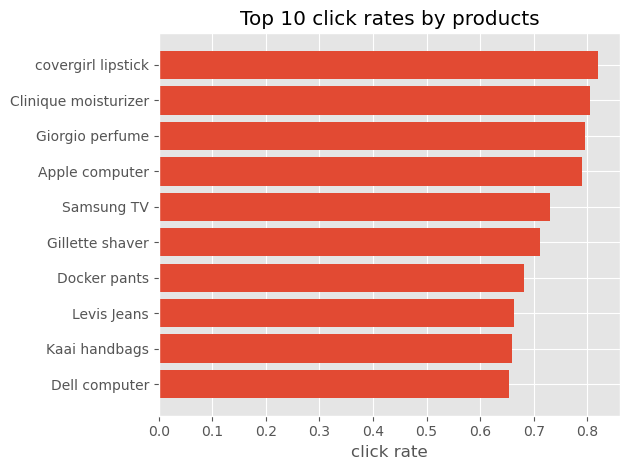

In [351]:
#Graph the result
click_rate_df = pd.DataFrame()
click_rate_df["product"] = product_l
click_rate_df["click_rate"] = click_rate_d.values()
click_rate_df.sort_values(by="click_rate", ascending=False, inplace=True)

plt.figure()
plt.title("Top 10 click rates by products")
plt.barh(
    range(10), click_rate_df["click_rate"].values[:10][::-1], 
    tick_label=click_rate_df["product"].values[:10][::-1]
)
plt.xlabel("click rate")
plt.tight_layout()

plt.savefig("figures/top_product_click_rate.png")
plt.show()

# 7. Compute click rate for each product/sentiment type

In [261]:
def compute_click_rate_sent(product, sentiment):
    """compute the click rate for each product conditioned on sentiment type"""
    #Find the product url
    product_url = products[
        products["product"] == product].product_URL.values[0]
    
    #subset data
    subset = log2[log2["product_url"] == product_url]
    
    # subset by sentiment type
    subset2 = subset[subset["sentiment"] == sentiment]
    
    #Compute click rate
    clicks = np.sum(subset2["click"])
    click_rate = clicks/len(subset2)
    
    return click_rate

In [376]:
prod_l = list()
sent_l = list()
click_l = list()
sentiment_l = ["positive", "negative", "neutral"]

for p in product_l:
    for s in sentiment_l:
        prod_l.append(p)
        sent_l.append(s)
        click_l.append(compute_click_rate_sent(p,s))

click_sentiment_df = pd.DataFrame()
click_sentiment_df["product"] = prod_l
click_sentiment_df["sentiment"] = sent_l
click_sentiment_df["click_rate"] = click_l

click_sentiment_df.sort_values(
    by="click_rate", ascending=False, inplace=True)
click_sentiment_df.head()

,product,sentiment,click_rate
149,covergirl lipstick,neutral,1.000000
147,covergirl lipstick,positive,1.000000
140,Tesla,neutral,0.987654
106,NemoK blender,negative,0.978261
47,Giorgio perfume,neutral,0.969697


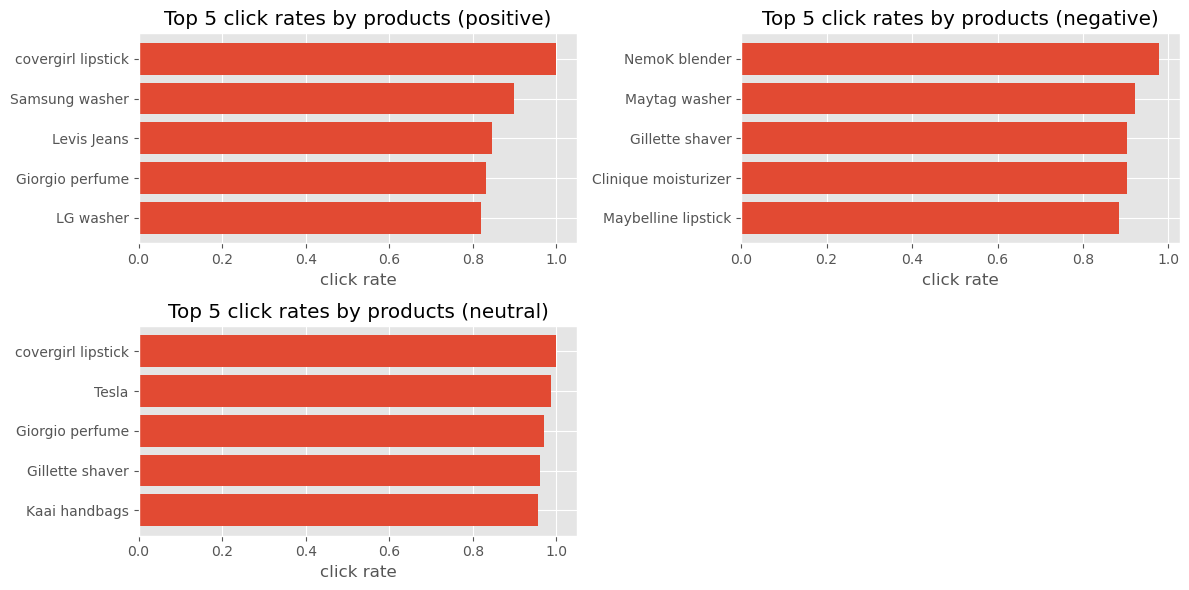

In [377]:
sentiment_l = ["positive", "negative", "neutral"]

plt.figure(figsize=(12,6))
for i in range(len(sentiment_l)):
    s = sentiment_l[i]
    sub_df = click_sentiment_df[click_sentiment_df["sentiment"] == s]
    sub_df.sort_values(by="click_rate", ascending=False)
    
    plt.subplot(2,2,i+1)
    title = "Top 5 click rates by products (" + str(s) +")"
    plt.title(title)
    plt.barh(
        range(5), sub_df["click_rate"].values[:5][::-1], 
        tick_label=sub_df["product"].values[:5][::-1]
    )
    plt.xlabel("click rate")
plt.tight_layout()
plt.savefig("figures/prod_click_sent.png")

# 8. Compute click rate for each product type

In [378]:
def compute_click_rate_ptype(product_type):
    """compute click rate for each product type"""
    #subset data
    subset = products[products["product_type"] == product_type]
    urls = np.unique(subset["product_URL"])
    
    #find all products within the product type
    subset2 = log2[log2["product_url"].isin(urls)]
    
    #Compute click rate
    clicks = np.sum(subset2["click"])
    click_rate = clicks/len(subset2)
    
    return click_rate

In [379]:
click_rate_ptype_d = dict()
for x in product_type_l:
    click_rate_ptype_d[x] = compute_click_rate_ptype(x)
click_rate_ptype_d

{'blender': 0.49923664122137407,
 'car': 0.3693304535637149,
 'coffee': 0.3552941176470588,
 'computer': 0.56,
 'dryer': 0.4529058116232465,
 'elliptical trainer': 0.5284090909090909,
 'face cream': 0.8055555555555556,
 'furniture': 0.5549738219895288,
 'jeans': 0.45174825174825173,
 'lipstick': 0.6656976744186046,
 'makeup': 0.2561576354679803,
 'pants': 0.6815286624203821,
 'perfume': 0.5668934240362812,
 'pressure cooker': 0.5,
 'refrigerator': 0.2872727272727273,
 'rowing machine': 0.22340425531914893,
 'shaver': 0.5369127516778524,
 'speakers': 0.5359801488833746,
 'tablet': 0.5019011406844106,
 'television': 0.5330578512396694,
 'treadmill': 0.4897119341563786,
 'vitamin': 0.628099173553719,
 'washer': 0.5182767624020888,
 "women's purse": 0.5151515151515151}

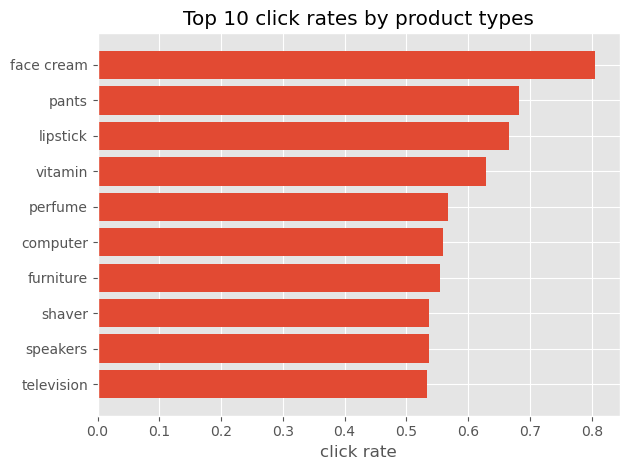

In [380]:
click_rate_ptype_df = pd.DataFrame()
click_rate_ptype_df["product_type"] = product_type_l
click_rate_ptype_df["click_rate"] = click_rate_ptype_d.values()
click_rate_ptype_df.sort_values(by="click_rate", ascending=False, inplace=True)

plt.figure()
plt.title("Top 10 click rates by product types")
plt.barh(
    range(10), click_rate_ptype_df["click_rate"].values[:10][::-1], 
    tick_label=click_rate_ptype_df["product_type"].values[:10][::-1]
)
plt.xlabel("click rate")
plt.tight_layout()
plt.savefig("figures/top_product_type_click_rate.png")
plt.show() 

# 9. Click rate for each product type by sentiment type

In [381]:
def compute_click_rate_sent_ptype(product_type, sentiment):
    """compute the click rate for each product type conditioned on sentiment type"""
    #Subset by product type
    subset = products[products["product_type"] == product_type]
    urls = np.unique(subset["product_URL"])
    
    #subset by product url
    subset2 = log2[log2["product_url"].isin(urls)]
    
    #subset by sentiment
    subset3 = subset2[subset2["sentiment"] == sentiment]
    
    #Compute click rate for each sentiment type
    clicks = np.sum(subset3["click"])
    click_rate = clicks/len(subset3)
    
    return click_rate

In [382]:
prod_l = list()
sent_l = list()
click_l = list()
sentiment_l = ["positive", "negative", "neutral"]

for p in product_type_l:
    for s in sentiment_l:
        prod_l.append(p)
        sent_l.append(s)
        click_l.append(compute_click_rate_sent_ptype(p,s))

click_sentiment_ptype_df = pd.DataFrame()
click_sentiment_ptype_df["product_type"] = prod_l
click_sentiment_ptype_df["sentiment"] = sent_l
click_sentiment_ptype_df["click_rate"] = click_l

click_sentiment_ptype_df.sort_values(
    by="click_rate", ascending=False, inplace=True)
click_sentiment_ptype_df.head()

,product_type,sentiment,click_rate
20,face cream,neutral,0.930556
19,face cream,negative,0.902778
41,pressure cooker,neutral,0.864407
34,pants,negative,0.835821
64,vitamin,negative,0.835294


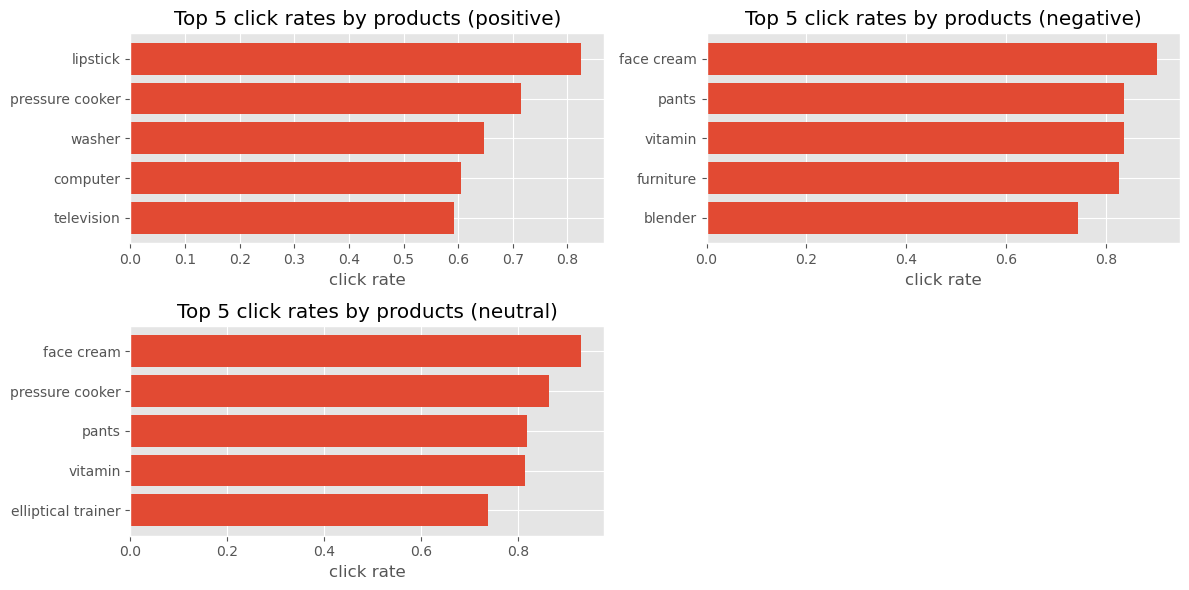

In [383]:
sentiment_l = ["positive", "negative", "neutral"]

plt.figure(figsize=(12,6))
for i in range(len(sentiment_l)):
    s = sentiment_l[i]
    sub_df = click_sentiment_ptype_df[click_sentiment_ptype_df["sentiment"] == s]
    sub_df.sort_values(by="click_rate", ascending=False)
    
    plt.subplot(2,2,i+1)
    title = "Top 5 click rates by products (" + str(s) +")"
    plt.title(title)
    plt.barh(
        range(5), sub_df["click_rate"].values[:5][::-1], 
        tick_label=sub_df["product_type"].values[:5][::-1]
    )
    plt.xlabel("click rate")
plt.tight_layout()
plt.savefig("figures/ptype_click_sent.png")

# 10. Save into database

Since we have both sentiment and the click rate features, appending to any existing tables will cause data redundancy issues. As a solution, we will create a new table, with product_type and sentiment as primary key. Since no other table uses product_type and sentiment type as primary key, and no other table uses the combination of the two features, we do not have any foreign key constraint. 

In [169]:
#Create dataframe
prod_type_click_df = pd.DataFrame()
prod_type_l = list()
sentiment_l = list()
click_rate_l = list()

for k, v in click_rate_ptype_sent_d.items():    
    for k1, v1 in v.items():
        prod_type_l.append(k)
        sentiment_l.append(k1)
        click_rate_l.append(v1)

prod_type_click_df["product_type"] = prod_type_l
prod_type_click_df["sentiment"] = sentiment_l
prod_type_click_df["click_rate"] = click_rate_l

prod_type_click_df.head(2)

,product_type,sentiment,click_rate
0,blender,positive,0.378788
1,blender,negative,0.742739


In [171]:
#Create table
sql = (
    "CREATE TABLE IF NOT EXISTS ads_r_us.prod_click_rate("
    "product_type varchar(255),"
    "sentiment varchar(255),"
    "click_rate float(5),"
    "PRIMARY KEY (product_type, sentiment));"
)
mycursor.execute(sql)

In [173]:
for x in prod_type_click_df.itertuples():
    sql = "INSERT INTO prod_click_rate VALUES (%s, %s, %s)"
    val = [x.product_type, x.sentiment, x.click_rate]
    mycursor.execute(sql, val)
mydb.commit()

In [175]:
#check the result
# https://www.w3schools.com/python/python_mysql_select.asp
mycursor.execute("SELECT * FROM prod_click_rate")
myresult = mycursor.fetchall()
myresult

[('blender', 'negative', 0.742739),
 ('blender', 'neutral', 0.337963),
 ('blender', 'positive', 0.378788),
 ('car', 'negative', 0.387755),
 ('car', 'neutral', 0.585526),
 ('car', 'positive', 0.152439),
 ('coffee', 'negative', 0.465278),
 ('coffee', 'neutral', 0.357143),
 ('coffee', 'positive', 0.241135),
 ('computer', 'negative', 0.505435),
 ('computer', 'neutral', 0.569106),
 ('computer', 'positive', 0.606061),
 ('dryer', 'negative', 0.327586),
 ('dryer', 'neutral', 0.730061),
 ('dryer', 'positive', 0.308642),
 ('elliptical trainer', 'negative', 0.491228),
 ('elliptical trainer', 'neutral', 0.737705),
 ('elliptical trainer', 'positive', 0.344828),
 ('face cream', 'negative', 0.902778),
 ('face cream', 'neutral', 0.930556),
 ('face cream', 'positive', 0.583333),
 ('furniture', 'negative', 0.825),
 ('furniture', 'neutral', 0.578947),
 ('furniture', 'positive', 0.27907),
 ('jeans', 'negative', 0.262745),
 ('jeans', 'neutral', 0.61165),
 ('jeans', 'positive', 0.511811),
 ('lipstick', 'neg

# 11. Determine the effects of viewer's gender

In [384]:
# Calculate the click rate for each product_type, sentiment, and gender
def calculate_click_gender(product_type, sentiment):
    #subset by product_type
    subset = products[products["product_type"] == product_type]
    urls = np.unique(subset["product_URL"])
    
    #find all matching products
    subset2 = log2[log2["product_url"].isin(urls)]
    
    subset3 = subset2[subset2["sentiment"] == sentiment]

    #subset by gender
    female = subset3[subset3["gender"] == "female"]
    male = subset3[subset3["gender"] == "male"]

    clicks_female = np.sum(female["click"])
    click_rate_f = clicks_female/len(female)

    clicks_male = np.sum(male["click"])
    click_rate_m = clicks_male/len(male)
    
    return (click_rate_f, click_rate_m)

In [385]:
#Create dataframe
prod_l = list()
sent_l = list()
click_rate_f_l = list()
click_rate_m_l = list()

sentiment_l = ["positive", "negative", "neutral"]

for p in product_type_l:
    for s in sentiment_l:
        click_rate_f, click_rate_m = calculate_click_gender(p, s)
        
        prod_l.append(p)        
        sent_l.append(s)        
        click_rate_f_l.append(click_rate_f)
        click_rate_m_l.append(click_rate_m)

clicks_gender_df = pd.DataFrame()
clicks_gender_df["product_type"] = prod_l
clicks_gender_df["sentiment"] = sent_l
clicks_gender_df["click_rate_f"] = click_rate_f_l
clicks_gender_df["click_rate_m"] = click_rate_m_l

clicks_gender_df.head(6)

,product_type,sentiment,click_rate_f,click_rate_m
0,blender,positive,0.377358,0.380435
1,blender,negative,0.695652,0.785714
2,blender,neutral,0.375000,0.291667
3,car,positive,0.128205,0.174419
4,car,negative,0.375000,0.397590
5,car,neutral,0.533333,0.636364


In [386]:
# Compute difference
clicks_gender_df["click_rate_diff"] = abs(clicks_gender_df[
    "click_rate_f"] - clicks_gender_df["click_rate_m"])

clicks_gender_df.head(3)

,product_type,sentiment,click_rate_f,click_rate_m,click_rate_diff
0,blender,positive,0.377358,0.380435,0.003076
1,blender,negative,0.695652,0.785714,0.090062
2,blender,neutral,0.375000,0.291667,0.083333


We define arbitrary threshold for difference as 5%. That is, if the absolute difference between the click rate for females and the click rate for males is greater than 0.05, then we say that there is a significant different.

In [387]:
significant_gender = clicks_gender_df[
    clicks_gender_df["click_rate_diff"] > 0.05]

significant_gender.sort_values(
    by="click_rate_diff", ascending=False, inplace=True)
print(significant_gender.shape)
significant_gender.head()

(41, 5)


C:\Users\Home\AppData\Local\Temp\ipykernel_880\3535858583.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_gender.sort_values(


,product_type,sentiment,click_rate_f,click_rate_m,click_rate_diff
32,makeup,neutral,0.270270,0.487805,0.217535
48,shaver,positive,0.312500,0.509434,0.196934
15,elliptical trainer,positive,0.240000,0.424242,0.184242
44,refrigerator,neutral,0.477273,0.304348,0.172925
43,refrigerator,negative,0.192308,0.026316,0.165992


# 12. Determine the effects of viewer's age groups

In [388]:
# Calculate the click rate for each product_type, sentiment, and age group
def calculate_click_age(product_type, sentiment, age_group):
    #subset by product_type
    subset = products[products["product_type"] == product_type]
    urls = np.unique(subset["product_URL"])
    
    #find all matching products
    subset2 = log2[log2["product_url"].isin(urls)]
    
    subset3 = subset2[subset2["sentiment"] == sentiment]

    #subset by age
    subset4 = subset3[subset3["age_group"] == age_group]
    
    clicks = np.sum(subset4["click"])
    click_rate = clicks/len(subset4)
    
    return click_rate

In [389]:
#Create dataframe
prod_l = list()
sent_l = list()
click_rate_young_l = list()
click_rate_middle_l = list()
click_rate_senior_l = list()
click_rate_juvenile_l = list()

for p in product_type_l:
    for s in sentiment_l:
        click_young = calculate_click_age(p, s, "young")
        click_middle = calculate_click_age(p, s, "middle-age")
        click_senior = calculate_click_age(p, s, "senior")
        click_juvenile = calculate_click_age(p, s, "juvenile")
        
        prod_l.append(p)        
        sent_l.append(s)        
        click_rate_young_l.append(click_young)
        click_rate_middle_l.append(click_middle)
        click_rate_senior_l.append(click_senior)
        click_rate_juvenile_l.append(click_juvenile)

clicks_age_df = pd.DataFrame()
clicks_age_df["product_type"] = prod_l
clicks_age_df["sentiment"] = sent_l
clicks_age_df["click_rate_young"] = click_rate_young_l
clicks_age_df["click_rate_middle"] = click_rate_middle_l
clicks_age_df["click_rate_senior"] = click_rate_senior_l
clicks_age_df["click_rate_juvenile"] = click_rate_juvenile_l


clicks_age_df.head(6)

,product_type,sentiment,click_rate_young,click_rate_middle,click_rate_senior,click_rate_juvenile
0,blender,positive,0.461538,0.297872,0.428571,0.320000
1,blender,negative,0.803279,0.738462,0.672727,0.750000
2,blender,neutral,0.316667,0.300000,0.418182,0.313725
3,car,positive,0.187500,0.106383,0.300000,0.051282
4,car,negative,0.361111,0.404762,0.416667,0.363636
5,car,neutral,0.523810,0.500000,0.720930,0.571429


In [390]:
# Compute the pairwise difference
age_cols = [
    "click_rate_young", "click_rate_middle", 
    "click_rate_senior", "click_rate_juvenile"
]

for i in range(len(age_cols)):
    for j in range(i+1, len(age_cols)):
        col1 = age_cols[i]
        col2 = age_cols[j]
        
        pairwise_diff = np.abs(
            clicks_age_df[col1] - clicks_age_df[col2]
        )
        col_name = col1.split("_")[-1] + "_" + col2.split("_")[-1]
        
        clicks_age_df[col_name] = pairwise_diff

clicks_age_df.head(6)

,product_type,sentiment,click_rate_young,click_rate_middle,click_rate_senior,click_rate_juvenile,young_middle,young_senior,young_juvenile,middle_senior,middle_juvenile,senior_juvenile
0,blender,positive,0.461538,0.297872,0.428571,0.320000,0.163666,0.032967,0.141538,0.130699,0.022128,0.108571
1,blender,negative,0.803279,0.738462,0.672727,0.750000,0.064817,0.130551,0.053279,0.065734,0.011538,0.077273
2,blender,neutral,0.316667,0.300000,0.418182,0.313725,0.016667,0.101515,0.002941,0.118182,0.013725,0.104456
3,car,positive,0.187500,0.106383,0.300000,0.051282,0.081117,0.112500,0.136218,0.193617,0.055101,0.248718
4,car,negative,0.361111,0.404762,0.416667,0.363636,0.043651,0.055556,0.002525,0.011905,0.041126,0.053030
5,car,neutral,0.523810,0.500000,0.720930,0.571429,0.023810,0.197121,0.047619,0.220930,0.071429,0.149502


In [391]:
# Decide if there is significant difference between pairs
age_diff_cols = [
    "young_middle", "young_senior", "young_juvenile", 
    "middle_senior", "middle_juvenile", "senior_juvenile"
]

significant_age_l = list()
for x in age_diff_cols:
    significant_age = clicks_age_df[["product_type", "sentiment", x]]
    significant_age = significant_age[significant_age[x] > 0.05]
    significant_age.sort_values(by=x, ascending=False, inplace=True)
    significant_age_l.append(significant_age)

In [392]:
for x in significant_age_l:
    print(x.head())

       product_type sentiment  young_middle
39  pressure cooker  positive      0.343874
51         speakers  positive      0.305305
45   rowing machine  positive      0.305195
30           makeup  positive      0.295238
46   rowing machine  negative      0.283333
          product_type sentiment  young_senior
45      rowing machine  positive      0.603175
17  elliptical trainer   neutral      0.283333
42        refrigerator  positive      0.258312
49              shaver  negative      0.222222
5                  car   neutral      0.197121
      product_type sentiment  young_juvenile
45  rowing machine  positive        0.664286
63         vitamin  positive        0.375000
30          makeup  positive        0.337662
51        speakers  positive        0.286787
21       furniture  positive        0.284193
          product_type sentiment  middle_senior
17  elliptical trainer   neutral       0.400000
32              makeup   neutral       0.318182
51            speakers  positive       0

# 13. Recommendations

## a. which ads generate most clicks given sentiment context?

C:\Users\Home\AppData\Local\Temp\ipykernel_880\3967573601.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.sort_values(by="click_rate", ascending=False, inplace=True)


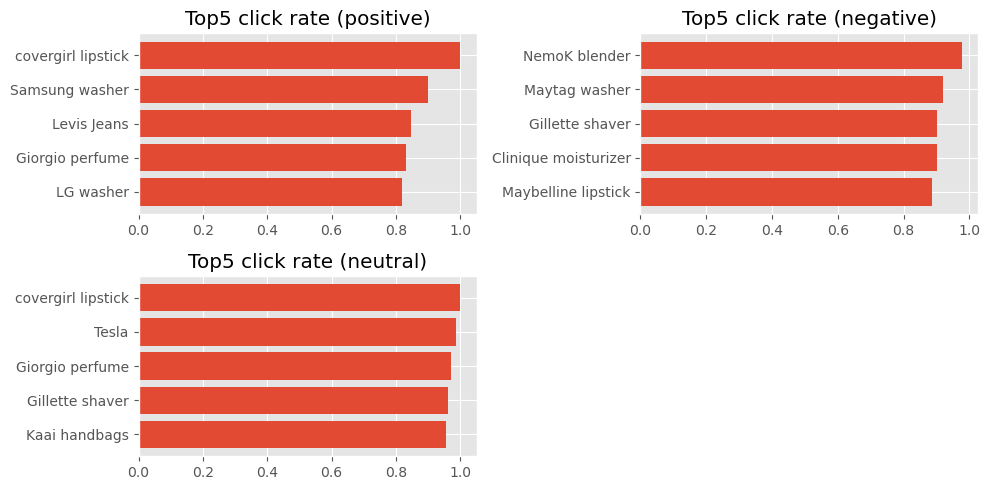

In [395]:
plt.figure(figsize=(10,5))
for i in range(len(sentiment_l)):
    plt.subplot(2,2,i+1)
    plt.title("Top5 click rate (" + str(sentiment_l[i]) + ")")
    
    sub_df = click_sentiment_df[
        click_sentiment_df["sentiment"] == sentiment_l[i]]
    sub_df.sort_values(by="click_rate", ascending=False, inplace=True)
    
    plt.barh(
        range(5), 
        sub_df["click_rate"].values[:5][::-1], 
        tick_label=sub_df["product"].values[:5][::-1])
    
plt.tight_layout()
plt.show()

Based on the above figure, top products with the highest click rate in positive context are covergirl lipstick, samsung washer, and Levis jeans. The products with the top click rate in negative context are NemoK blender, Maytag washer, and Gillete shaver. The products with the top click rate in neutral context are the covergirl lipstick, Tesla, and Giorgio perfume. I recommend taht the company place ads for covergirl lipstick within positive and neutral contexts, and NemoK blender within neutral contexts.

## b.which ads generate most clicks given sentiment context and viewer genders?

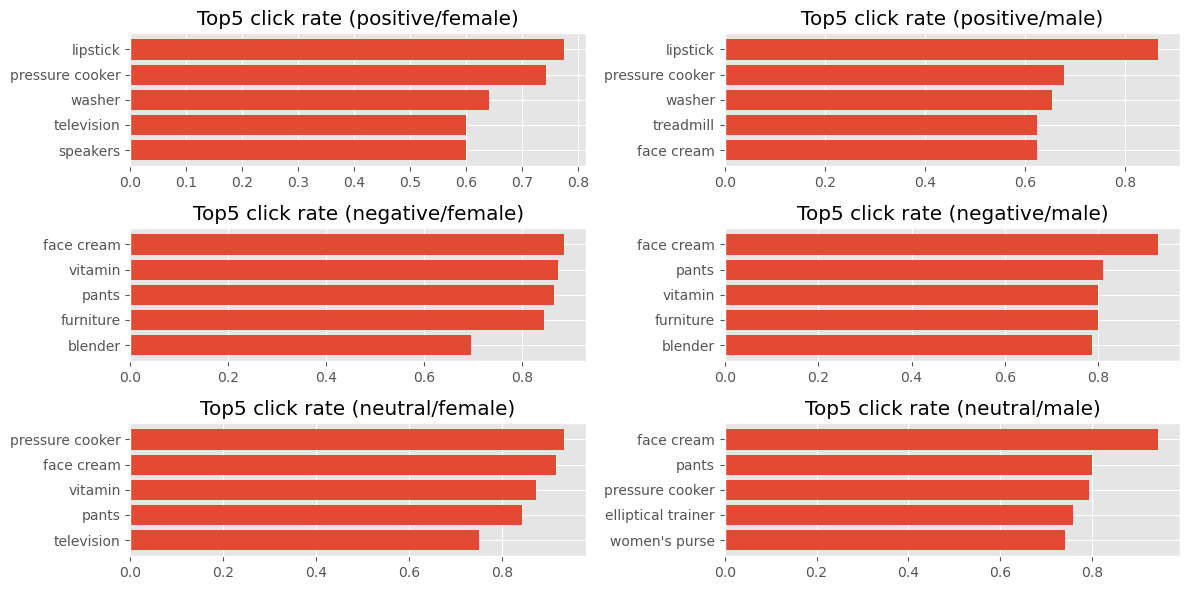

In [400]:
gender_l = ["female", "male"]

plt.figure(figsize=(12,6))
cnt = 1
for i in range(len(sentiment_l)):
    for j in range(len(gender_l)):
        plt.subplot(3,2,cnt)
        plt.title(
            "Top5 click rate (" + 
            str(sentiment_l[i]) + "/" +
            str(gender_l[j]) + ")"
        )
        
        gender = gender_l[j]
        if gender == "female":
            sub_df = clicks_gender_df[[
                "product_type", "sentiment", "click_rate_f"]]
        if gender == "male":
            sub_df = clicks_gender_df[[
                "product_type", "sentiment", "click_rate_m"]]

        sub_df = sub_df[(sub_df["sentiment"] == sentiment_l[i])]
        sub_df.sort_values(
            by=sub_df.columns[-1], ascending=False, inplace=True)

        plt.barh(
            range(5), 
            sub_df[sub_df.columns[-1]].values[:5][::-1], 
            tick_label=sub_df["product_type"].values[:5][::-1])
        cnt += 1

plt.tight_layout()
plt.savefig("figures/click_rate_gender.png")
plt.show()

For females, the product type with the top click rate is lipstick within positive context, face cream within negative context, and pressure cooker within neutral context. For males, the product with the highest click rate is lipstick within positive context and face cream within negative context and neutral context. I recommend that the company choose those product types and sentiment context when targeting the specific demographic groups. 

## c.which ads generate most clicks given sentiment context and viewer age groups?

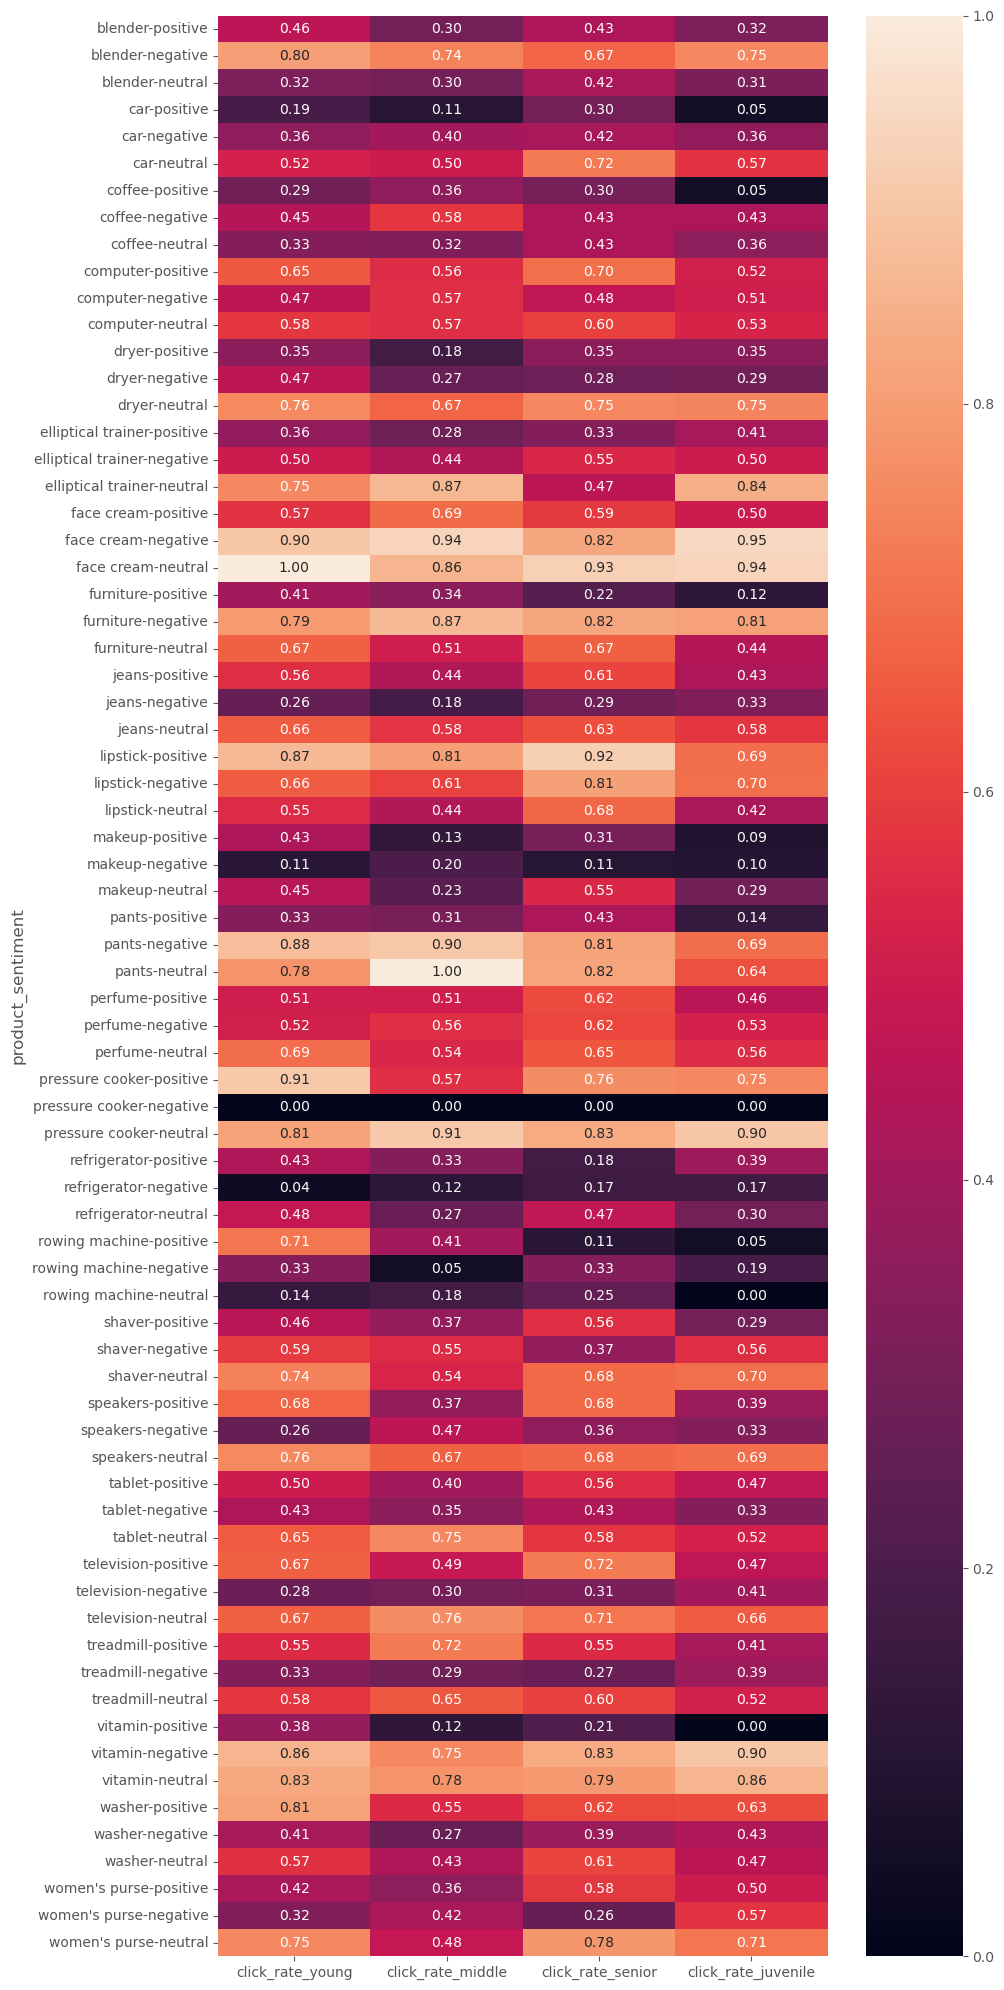

In [320]:
heat_map_df = pd.DataFrame()
heat_map_df["product_sentiment"] = (
    clicks_age_df["product_type"] + "-" + clicks_age_df["sentiment"]
).values
heat_map_df.set_index("product_sentiment", inplace=True)
heat_map_df["click_rate_young"] = clicks_age_df["click_rate_young"].values
heat_map_df["click_rate_middle"] = clicks_age_df["click_rate_middle"].values
heat_map_df["click_rate_senior"] = clicks_age_df["click_rate_senior"].values
heat_map_df["click_rate_juvenile"] = clicks_age_df["click_rate_juvenile"].values

plt.figure(figsize=(10, 20))
sns.heatmap(heat_map_df, annot=True, fmt=".2f")
plt.tight_layout()
plt.show()

From the figure above, we see that the product with the highest click rate is face cream in a neutral sentiment setting for young an dsenior audiences, pants in neutral sentiment for middle-age audiences, and face cream in a negative sentiment for juvenile audiences. To best target each demographic group, the ads company should place the highest-clicked ads in each age category in the corresponding sentiment environment.

# Reference

https://en.wikipedia.org/wiki/Jaccard_index [1]